In [223]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import gamma, factorial
import tqdm
from scipy.stats import t

In [118]:
def f(x, r=1):
    '''
    If the squared Norm of the input vector < r then return 1, else, Return 0
    '''
    if np.sum(x ** 2) < r:
        return 1
    else:
        return 0

In [90]:
def mc_integrate(f, lower_lim=0, upper_lim=1, samples = 10000, dimensions = 2):
    """
    Integrates a function using the monte carlo
    integration algorithm, generalised for multiple dimensions
    """
    dist = np.random.uniform(low=lower_lim,
                             high=upper_lim,
                             size=(samples + 1, dimensions))
    coefficient = ((upper_lim - lower_lim) ** dimensions) / samples
    y = np.zeros(dist.shape[0])
    for i, val in enumerate(dist):
        y[i] = f(val)
    summation = np.sum(y)

    return dist, y, coefficient * summation

In [187]:
def error(estimated_value, dimensions = 2):
    '''
    Find the absolute error between the estimated value of the integral and the true value
    '''
    return abs(estimated_value - unit_hypersphere_volume(2))


In [140]:
def circle(theta, r = 1):
    '''
    given an angle, theta, returns the corresponding cartesian coordinates of the point on a circle
    '''
    return r * np.cos(theta), r * np.sin(theta)

In [144]:
def plot_mc_integration(ax, ax_x, ax_y, samples):
    points, in_range, value = mc_integrate(f, lower_lim=-1, upper_lim=1, samples = samples, dimensions = 2)

    # plot the points that were sampled from the uniform distribution
    ax[ax_x][ax_y].scatter(points[:,0], points[:,1], color = cm.bwr(in_range))

    # Draw the region over which the integral is calculated
    theta = np.linspace(0, np.pi * 2, 100)
    x,y = circle(theta)
    ax[ax_x][ax_y].plot(x,y)
    return error(value)

<Figure size 432x288 with 0 Axes>

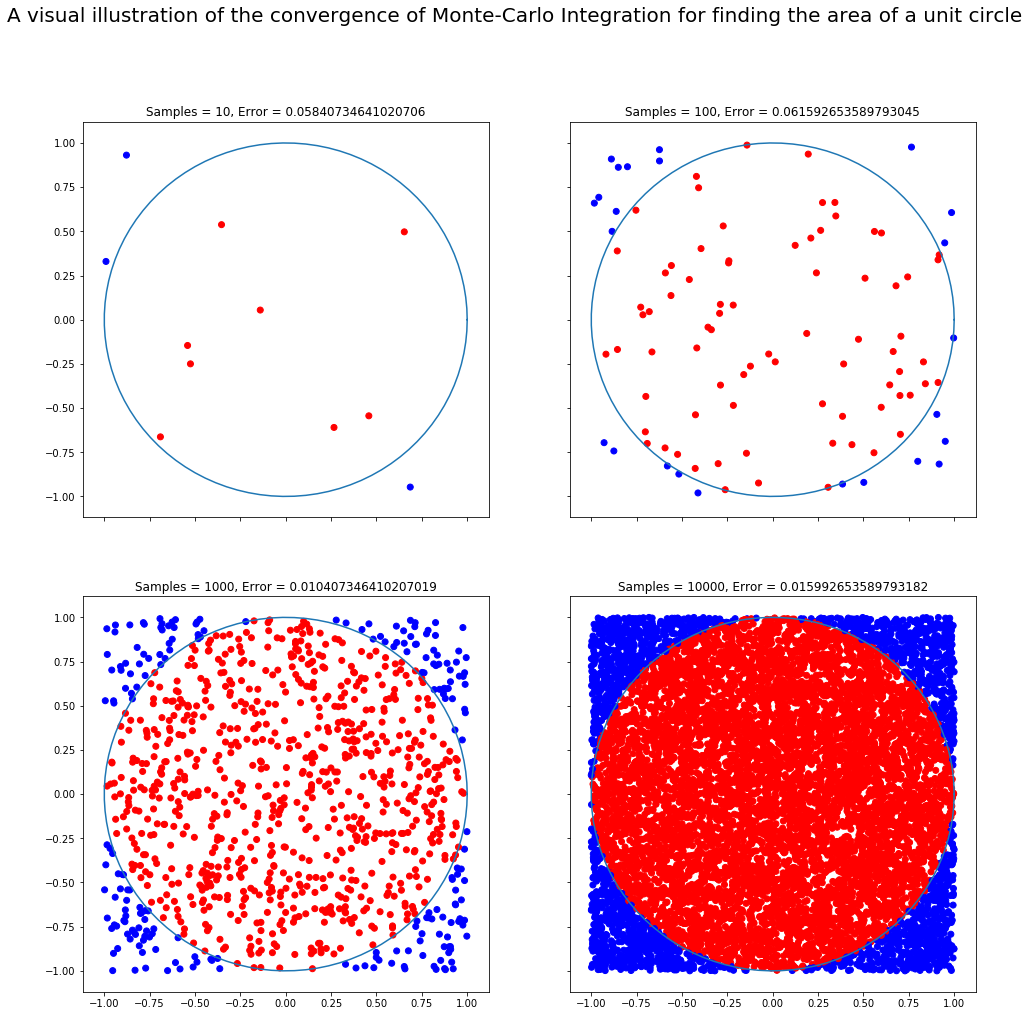

In [189]:
fig = plt.figure()    
fig, ax = plt.subplots(nrows = 2, ncols = 2, sharex=True, sharey = True, figsize = (16,16))

for ax_x in range(2):
    for ax_y in range(2):
        samples = 10 ** (1 + ax_y + 2 * ax_x)
        err = plot_mc_integration(ax, ax_x, ax_y, samples)
        ax[ax_x][ax_y].title.set_text('Samples = {}, Error = {}'.format(samples, err))
plt.suptitle('A visual illustration of the convergence of Monte-Carlo Integration for finding the area of a unit circle', size=20)
plt.show()

<h3>The effect of increasing dimensions on convergence</h3>
According to the proof detailed in the previous homework, the error term is given by $\frac{V}{\sqrt{N}}\sqrt{Var(f)}$ and is thus independent of number of dimensions. 

Below is a function that calculated the volume of a unit hypersphere, obtained from NIST: https://dlmf.nist.gov/5.19#E4. As one might imagine, the volume changes with number of dimensions:
$$Vol = \frac{r^{n}\pi ^{\frac{n}{2}}}{\Gamma (\frac{n}{2} + 1)}$$
Where $r$ is the radius of the hypersphere and $n$ is number of dimensions.

For the case of a unit hypersphere, $r = 1$.  This slightly simplifies the equation to:
$$Vol = \frac{\pi ^{\frac{n}{2}}}{\Gamma (\frac{n}{2} + 1)}$$

Which has been codified into python below.

This means that the error for each integration can be calculated as
$$\frac{V}{N}\sum_{i=1}^{N}f(\mathbf{x_{i}}) - \frac{\pi ^{\frac{n}{2}}}{\Gamma (\frac{n}{2} + 1)}$$

It is important to note here that $V$ and $Vol$ are different. $V$ is the area over which the integration is performed, in this case this is a hypercube of length 2:
$$V = l^{n} = 2^{n}$$
Where $l$ is side length

Thus, given that $Var(f) = const$, if one divides Error by Volume, the result should converge proportional to $\frac{1}{\sqrt{N}}$ regardless of number of dimensions.

This has been explored below:

In [191]:
def unit_hypersphere_volume(n):
    '''
    Returns the volume of a unit hypersphere in n dimensions
    '''
    numerator = np.pi ** (n/2)
    denominator = gamma((n/2) + 1)
    return numerator / denominator

0.025289795213608635

In [204]:
convergence = {}
samples = [2 ** power for power in range(1, 15)]
# Iterate over 1-10 dimensional space
for dim in tqdm.tqdm_notebook(range(1, 10)):
    # Iterate over a sample size from 2^1 to 2^15
    for sample in samples:
        _, _, value = mc_integrate(f, lower_lim=-1, upper_lim=1, samples=sample, dimensions=3)    
        # calculate absolute error
        error = abs(value - unit_hypersphere_volume(3))
        
        # Store the result in a dictionary for handy access later
        try:
            convergence[dim].append(error)
        except KeyError:
            convergence[dim] = [error]

Gradient of convergence for dimension 1: -0.6767830303862887
Gradient of convergence for dimension 2: -0.5214533391059557
Gradient of convergence for dimension 3: -0.4726756372053978
Gradient of convergence for dimension 4: -0.6393902263176867
Gradient of convergence for dimension 5: -0.42061300143139446
Gradient of convergence for dimension 6: -0.6385981052307236
Gradient of convergence for dimension 7: -0.5476260475714575
Gradient of convergence for dimension 8: -0.6417103012844433
Gradient of convergence for dimension 9: -0.5502923072926866


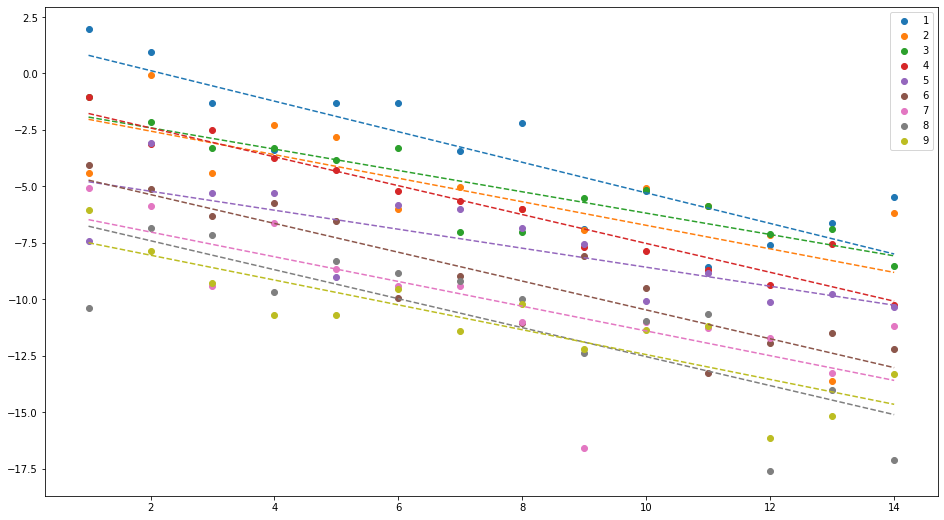

In [216]:
x = np.log2(samples)
plt.figure(figsize = (16,9))
gradients = np.zeros(len(convergence.keys()))

for dim, y in convergence.items():
    # Plot a log-log graph of error against number of samples 
    # for each dimensionality
    
    integral_domain_volume = 2 ** dim
    y = np.array(y)
    y = np.log2(y / integral_domain_volume) # Divide the error by the volume of the integral domain
    plt.scatter(x, y, label=dim)
    
    coef = np.polyfit(x, y, 1)
    print('Gradient of convergence for dimension {}: {}'.format(dim, coef[0]))
    gradients[dim - 1] = coef[0]
    poly1d_fn = np.poly1d(coef)
    plt.plot(x, poly1d_fn(x), '--')
plt.legend()

As can be seen above, it does not look like the gradient of convergence is affected by number of dimensions. To be sure, A two sided t test is performed with the hypothesis that sample mean $\mu_{0} = -0.5$ below:

In [249]:
mu_0 = -0.5
mean_x = gradients.mean()
sigma = np.sqrt(gradients.var())
n = len(gradients)

t_val = np.sqrt(n) * (abs(mean_x - mu_0)/sigma)
display(t_val)

2.4653009859959383

In [259]:
t_perc_point = t.pdf(t_val, n)
print('Percentage point in t distribution = {}'.format(t_perc_point))

Percentage point in t distribution = 0.029404010300898422


As the percentage point is below the critical threshold of 0.05, we can accept the hypothesis that $\mu_{0} = -0.5$, as was predicted theoretically.